In [2]:
import PyPDF2
import io
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import seaborn as sns
from statsmodels.regression.linear_model import WLS, OLS
from sklearn.preprocessing import StandardScaler


# Creating the Dataframe

In [3]:
huc12_watershed_data = pd.read_csv("C:/Users\lilyd\Desktop/arcstuff\hucinws.csv")
bmp_data = pd.read_csv("C:/Users/lilyd/Downloads/NPS.Loadings.Formatted_Copy.csv",encoding='unicode_escape')
bmp_n_reduct = bmp_data.groupby('huc12').agg({'TNLoadReduction':'sum'}).reset_index()
cropdata = pd.read_csv("C:/Users\lilyd\Desktop/arcstuff\cultcropinws.csv")
agtiledata = pd.read_csv("C:/Users\lilyd\Desktop/arcstuff/agtileinws.csv")
pasturedata = pd.read_csv("C:/Users\lilyd\Desktop/arcstuff\pastureinws.csv")
septicdata = pd.read_csv("C:/Users\lilyd\Desktop/arcstuff\septdens_perc.csv")
wastewaterflow = pd.read_csv("C:/Users\lilyd\Desktop/arcstuff\munis_flowsum.csv")
cafo = pd.read_csv("C:/Users\lilyd\Desktop/arcstuff\cafoinws.csv")

In [4]:
sumsize = cafo['sum_Size']
cafocnt = cafo['Point_Coun']
larges = sumsize-cafocnt
smalls = cafocnt-larges
cafo['small'] = smalls
cafo['large']=larges

In [5]:
huc12_watershed_data['bmp_load']=0.0
for i in range(len(huc12_watershed_data)):
    huc = huc12_watershed_data.iloc[i,0]
    bp = bmp_n_reduct[bmp_n_reduct['huc12']==huc]
    if bp.empty==False:
        huc12_watershed_data.iloc[i,4]=bp['TNLoadReduction']*huc12_watershed_data.iloc[i,3]/100
bmps = huc12_watershed_data.groupby('Name')['bmp_load'].agg('sum')

In [6]:
culcrop = cropdata[['Name','MAJORITY_P']]
summar = pd.DataFrame(bmps)
summar['Cultivated_Prop'] = 0.0
culcrop['MAJORITY_P']/=100

for i in culcrop['Name']:
    ugh = culcrop[culcrop['Name']==i]
    summar.loc[i,'Cultivated_Prop']=ugh['MAJORITY_P'].values
    

C:\Users\lilyd\AppData\Local\Temp\ipykernel_11456\3402667147.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  culcrop['MAJORITY_P']/=100


In [7]:
pasture = pasturedata[['Name','MAJORITY_P']]
summar['Pasture_Prop'] = 0.0
pasture['MAJORITY_P']/=100
for i in pasture['Name']:
    ugh = pasture[pasture['Name']==i]
    summar.loc[i,'Pasture_Prop']=ugh['MAJORITY_P'].values
    

C:\Users\lilyd\AppData\Local\Temp\ipykernel_11456\1020683023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pasture['MAJORITY_P']/=100


In [8]:
tile = agtiledata[['Name','MAJORITY_P']]
summar['Tile_Prop'] = 0.0
tile['MAJORITY_P']/=100
for i in tile['Name']:
    ugh = tile[tile['Name']==i]
    summar.loc[i,'Tile_Prop']=ugh['MAJORITY_P'].values

C:\Users\lilyd\AppData\Local\Temp\ipykernel_11456\1014452084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tile['MAJORITY_P']/=100


In [9]:
septicdata['PERCENTAGE']/=100
septicdata['areakm2'] = septicdata['AREA']/1000000

septicdata['septics'] = septicdata['sepden_km2']*septicdata['areakm2']
septicweight = septicdata.groupby('Name').agg('sum')

septicweight.reset_index(inplace=True)
summar['septicsystems'] = 0.0
for i in septicweight['Name']:
    ugh = septicweight[septicweight['Name']==i]
    summar.loc[i,'septicsystems']=ugh['septics'].values

In [10]:
#wastewaterflow
summar['munisww'] = 0.0
ww = wastewaterflow[['Name','SUM_Averag']]
for i in ww['Name']:
    ugh = ww[ww['Name']==i]
    summar.loc[i,'munisww']=ugh['SUM_Averag'].values

In [11]:
summar['medium_cafo'] = 0.0
summar['large_cafo']=0.0
smal = cafo[['Name','small']]
big = cafo[['Name','large']]
for i in smal['Name']:
    ughs = smal[smal['Name']==i]
    ughl = big[big['Name']==i]
    summar.loc[i,'medium_cafo']=ughs['small'].values
    summar.loc[i,'large_cafo']=ughl['large'].values

In [12]:
sample = pd.read_csv("C:/Users\lilyd\Desktop/arcstuff\mergedstreamstat.csv")
sampleslice = sample[['Name','AverageSam','SampleCoun']]
summar['Avgsample'] = 0.0
summar['Samplecount'] = 0
for i in sample['Name']:
    ugh = sample[sample['Name']==i]
    summar.loc[i,'Avgsample']=ugh['AverageSam'].values
    summar.loc[i,'Samplecount']=ugh['SampleCoun'].values

Normalize by area. For land with cultivated crops, normalize tile_prop by crop_prop. It would not be expected that there is tile land in uncultivated land, but if there is it is already normalized by land area.

In [13]:
for i in sample['Name']:
    slized = summar.loc[i]
    if slized['Cultivated_Prop']!=0.000000:
        if slized['Tile_Prop']>slized['Cultivated_Prop']:
            summar.loc[i,'Tile_Prop'] = 1
        else:
            summar.loc[i,'Tile_Prop'] = summar.loc[i,'Tile_Prop']/summar.loc[i,'Cultivated_Prop']
stst = pd.read_csv("C:/Users\lilyd\Desktop/arcstuff\mergedstreamstat.csv")
name_size = stst[['Name','areaskqm']]
for i in stst['Name']:
    ugh = stst[stst['Name']==i]
    summar.loc[i,'bmp_load']/=ugh['areaskqm'].values
    summar.loc[i,'septicsystems']/=ugh['areaskqm'].values
    summar.loc[i,'munisww']/=ugh['areaskqm'].values
    summar.loc[i,'medium_cafo']/=ugh['areaskqm'].values
    summar.loc[i,'large_cafo']/=ugh['areaskqm'].values

# Handling the Frame

In [15]:
allcrop = pd.DataFrame(summar)
onlycrop = pd.DataFrame(summar)
onlycrop = onlycrop[onlycrop['Cultivated_Prop']>0.10]
allcrop.reset_index(inplace=True)
onlycrop.reset_index(inplace=True)

In [274]:
unlybp = onlycrop[onlycrop['bmp_load']>0.0]
x_tile = np.sqrt(unlybp['Tile_Prop'])
y_bm = unlybp['bmp_load']
y_bm = np.log(y_bm/unlybp['Cultivated_Prop'])
tilbp = OLS(y_bm,x_tile).fit()
tilbp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.265
Model:                            OLS   Adj. R-squared (uncentered):              0.262
Method:                 Least Squares   F-statistic:                              98.44
Date:                Mon, 05 May 2025   Prob (F-statistic):                    5.18e-20
Time:                        23:33:55   Log-Likelihood:                         -791.55
No. Observations:                 274   AIC:                                      1585.
Df Residuals:                     273   BIC:                                      1589.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Tile_Prop      4.0948      0.413      9.921      0.000       3.282       4.907
==============================================================================
Omnibus:                       33.373   Durbin-Watson:                   1.115
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.796
Skew:                          -0.931   Prob(JB):                     8.40e-10
Kurtosis:                       3.441   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

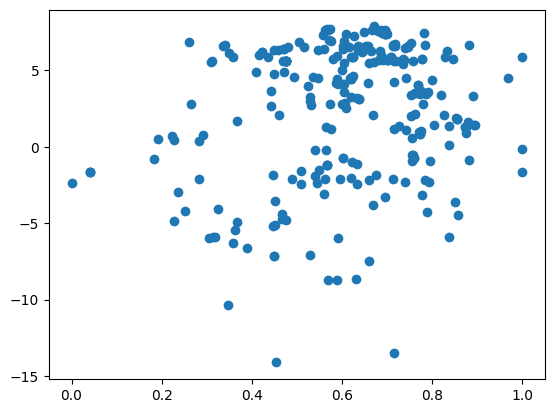

In [275]:
plt.scatter(x_tile,y_bm)

In [279]:
cc = onlycrop[onlycrop['Tile_Prop']>0.0]

bptoo = cc[cc['bmp_load']>0.0]
bpcrop = onlycrop[onlycrop['bmp_load']>0.0]

print(len(bptoo))
print(len(cc))
print(len(onlycrop))
print(len(bpcrop))

273
286
290
274


In [290]:
allbnp = summar[summar['bmp_load']>0.0]
allbpnocult = allbnp[allbnp['Cultivated_Prop']<=0.0]
print(len(allbpnocult))
len(summar[summar['Cultivated_Prop']<=0.0])

97


1018

# Change one for removing bmp


In [35]:
#separate y vals, counts (weights), and variables
y_only = pd.DataFrame(onlycrop['Avgsample'])
onlycounts = onlycrop['Samplecount']
y_all = pd.DataFrame(allcrop['Avgsample'])
allcounts = allcrop['Samplecount']
x_only = pd.DataFrame(onlycrop)
x_only.drop(['Name','Avgsample','Samplecount','bmp_load'],axis=1,inplace=True)
x_all = pd.DataFrame(allcrop)
x_all.drop(['Name','Avgsample','Samplecount','bmp_load'],axis=1,inplace=True)

#transform data
x_all = np.sqrt(x_all)
x_only = np.sqrt(x_only)
y_only = np.log(y_only)
y_all = np.sqrt(y_all)

#scale data
scaler = StandardScaler()
scaledx_all = scaler.fit_transform(x_all)
scaledy_all = scaler.fit_transform(y_all)
scaledx_only = scaler.fit_transform(x_only)
scaledy_only = scaler.fit_transform(y_only)

colvars = allcrop.columns
names=allcrop['Name']
namesonly = onlycrop['Name']
colvars = colvars[1:-2] #drops the y valuse
colvars = colvars.drop('bmp_load')

scaledx_alldf=pd.DataFrame(scaledx_all,columns=colvars,index=names)
scaledx_onlydf=pd.DataFrame(scaledx_only,columns=colvars,index=namesonly)

In [36]:
cols = allcrop.columns
cols = cols[1:-2] #drops the y values and name column
cols = cols.drop('bmp_load')
b=[]
multiplesxall = []
multxonly=[]
for i in range(len(cols)):
    a = i+1
    while a < len(cols): #gives us the multiplicative columns
        b.append(f'{cols[i]}*{cols[a]}')
        multiplesxall.append(scaledx_alldf[cols[i]]*scaledx_alldf[cols[a]])
        multxonly.append(scaledx_onlydf[cols[i]]*scaledx_onlydf[cols[a]]) #doesn't matter that not all names are in the short df. it only returns a value if it's there
        a+=1


b=np.array(b)
multiplesxall=np.array(multiplesxall)
multxonly=np.array(multxonly)

multiplesxall = np.transpose(multiplesxall)
multxonly = np.transpose(multxonly)
additionsxall = pd.DataFrame(multiplesxall,columns=b)
additionsxonly = pd.DataFrame(multxonly,columns=b)

In [37]:
scaledx_alldf.reset_index(inplace=True)
newdfxall = pd.concat([scaledx_alldf,additionsxall],axis=1)
scaledx_onlydf.reset_index(inplace=True)
newdfxonly = pd.concat([scaledx_onlydf,additionsxonly],axis=1)

# Quick Visualization

                 Cultivated_Prop  Pasture_Prop  Tile_Prop  septicsystems  \
Cultivated_Prop              NaN           NaN        NaN            NaN   
Pasture_Prop            0.505973           NaN        NaN            NaN   
Tile_Prop               0.685880      0.683910        NaN            NaN   
septicsystems           0.284963      0.480047   0.388630            NaN   
munisww                 0.130776      0.214200   0.227663       0.138791   
medium_cafo             0.220919      0.091661   0.157897       0.048562   
large_cafo              0.395125      0.264214   0.265131       0.138556   

                  munisww  medium_cafo  large_cafo  
Cultivated_Prop       NaN          NaN         NaN  
Pasture_Prop          NaN          NaN         NaN  
Tile_Prop             NaN          NaN         NaN  
septicsystems         NaN          NaN         NaN  
munisww               NaN          NaN         NaN  
medium_cafo      0.027296          NaN         NaN  
large_cafo       0.0

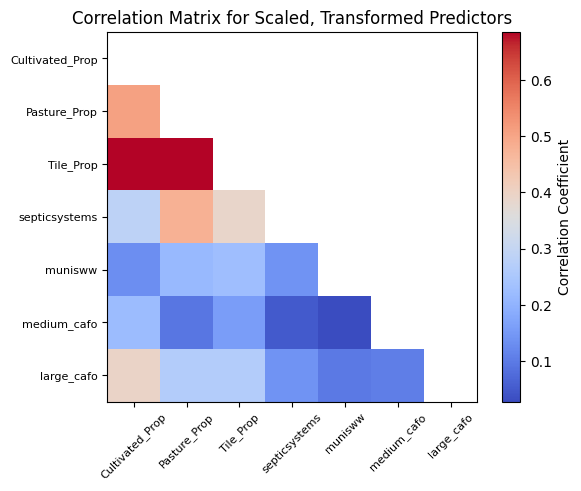

In [19]:
correlations = (scaledx_alldf.drop('Name',axis=1)).corr()
#plt.figure(figsize=(4,4))
#mask syntax from the pyplot documentation
mask = np.zeros_like(correlations, dtype=bool)
mask[np.triu_indices_from(mask)] = True
correlations[mask] = np.nan
print(correlations)
plt.imshow(correlations,cmap='coolwarm')
clb = plt.colorbar(cmap='coolwarm')
clb.set_label('Correlation Coefficient')
plt.xticks(range(len(correlations.columns)), correlations.columns, fontsize=8,rotation=45)
plt.yticks(range(len(correlations.columns)), correlations.columns,fontsize=8)
plt.title('Correlation Matrix for Scaled, Transformed Predictors')
plt.show()

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as wif
bean = pd.DataFrame(scaledx_alldf)
bean.drop('Name', inplace=True, axis=1)
print('The VIF for large is ',wif(bean,6))
print('The VIF for small is ',wif(bean,5))
print('The VIF for municipal waste is ',wif(bean,4))
print('The VIF for septic systems is ',wif(bean,3))
print('The VIF for Pastureland is ',wif(bean,2))
print('The VIF for tileprop is ',wif(bean,1))
print('The VIF for cropprop is ',wif(bean,0))
#print('The VIF for bmps is ',wif(scaledx_alldf,0))

The VIF for large is  1.2005887434352194
The VIF for small is  1.0533070172423948
The VIF for municipal waste is  1.0669186308535958
The VIF for septic systems is  1.3125593817460997
The VIF for Pastureland is  2.718282389132573
The VIF for tileprop is  2.1309415077506926
The VIF for cropprop is  2.1337252909065354


So the VIFs are still low, despite the correlations being somewhat high.

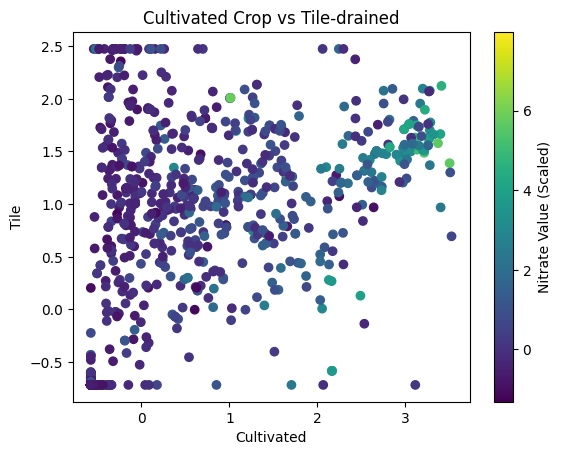

In [21]:
plt.scatter(scaledx_alldf['Cultivated_Prop'],scaledx_alldf['Tile_Prop'],c=scaledy_all)
cbr = plt.colorbar()
cbr.set_label('Nitrate Value (Scaled)')
plt.title('Cultivated Crop vs Tile-drained')
plt.xlabel('Cultivated')
plt.ylabel('Tile')
plt.show()

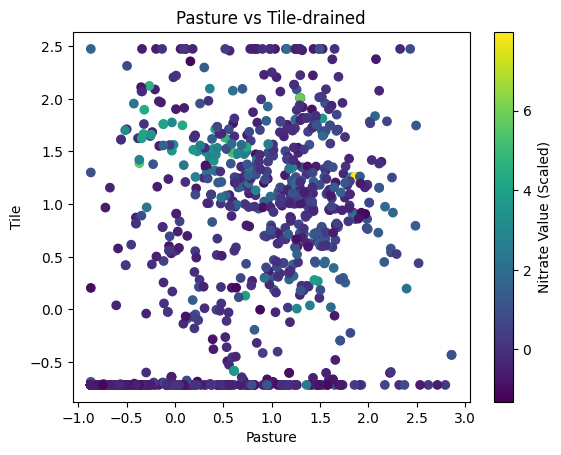

In [22]:
plt.scatter(scaledx_alldf['Pasture_Prop'],scaledx_alldf['Tile_Prop'],c=scaledy_all)
cbr = plt.colorbar()
cbr.set_label('Nitrate Value (Scaled)')
plt.title('Pasture vs Tile-drained')
plt.xlabel('Pasture')
plt.ylabel('Tile')
plt.show()

In [23]:
correlations = scaledx_onlydf.corr()
#plt.figure(figsize=(4,4))
#mask syntax from the pyplot documentation
mask = np.zeros_like(correlations, dtype=bool)
mask[np.triu_indices_from(mask)] = True
correlations[mask] = np.nan
print(correlations)
plt.imshow(correlations,cmap='coolwarm')
clb = plt.colorbar(cmap='coolwarm')
clb.set_label('Correlation Coefficient')
plt.xticks(range(len(correlations.columns)), correlations.columns, fontsize=8,rotation=45)
plt.yticks(range(len(correlations.columns)), correlations.columns,fontsize=8)
plt.title('Correlation Matrix for Scaled, Transformed Predictors (only cultivated)')
plt.show()

ValueError: could not convert string to float: '21NYDECA_WQX-01021067'

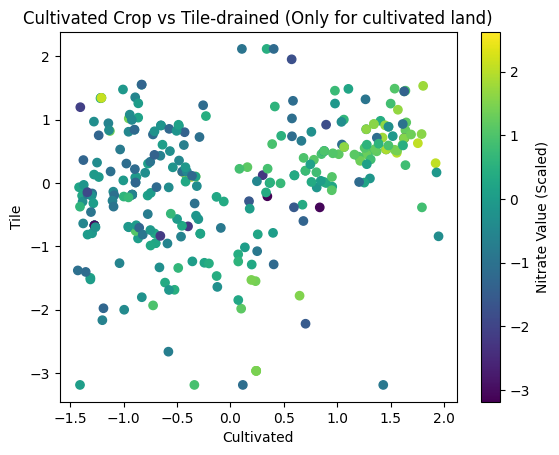

In [24]:
plt.scatter(scaledx_onlydf['Cultivated_Prop'],scaledx_onlydf['Tile_Prop'],c=scaledy_only)
cbr = plt.colorbar()
cbr.set_label('Nitrate Value (Scaled)')
plt.title('Cultivated Crop vs Tile-drained (Only for cultivated land)')
plt.xlabel('Cultivated')
plt.ylabel('Tile')
plt.show()

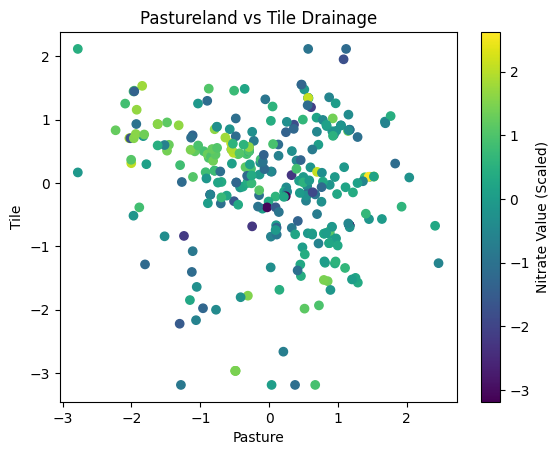

In [29]:
plt.scatter(scaledx_onlydf['Pasture_Prop'],scaledx_onlydf['Tile_Prop'],c=scaledy_only)
cbr = plt.colorbar()
cbr.set_label('Nitrate Value (Scaled)')
plt.title('Pastureland vs Tile Drainage')
plt.xlabel('Pasture')
plt.ylabel('Tile')
plt.show()

# We have four X dataframes, 2 counts, and 2 y's:

scaledx_alldf: no interactive effects, includes uncultivated land

scaledx_onlydf: no interactive effects, only includes cultivated land

newdfxall: interactive effects, includes uncultivated land

newdfxonly: interactive effects, only includes cultivated land

scaledy_all: avg sample, includes uncultivated land

scaledy_only: avg sample, only includes cultivated land

allcounts and onlycounts

In [250]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

# Model selection stuff (from last yr)

In [253]:
linreg =OLS(scaledy_only,scaledx_only).fit()
print(linreg.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.224
Model:                            OLS   Adj. R-squared (uncentered):              0.205
Method:                 Least Squares   F-statistic:                              11.69
Date:                Sat, 03 May 2025   Prob (F-statistic):                    4.62e-13
Time:                        11:51:55   Log-Likelihood:                         -374.67
No. Observations:                 290   AIC:                                      763.3
Df Residuals:                     283   BIC:                                      789.0
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Text(0, 0.5, 'Residual Value')

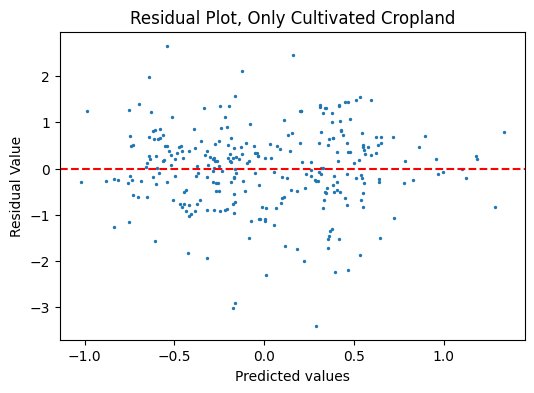

In [254]:
resid = linreg.resid
plt.figure(figsize=(6,4))
plt.scatter(linreg.fittedvalues,linreg.resid,s=2)
plt.axhline(0,linestyle='--',color='r')
plt.title('Residual Plot, Only Cultivated Cropland')
plt.xlabel('Predicted values')
plt.ylabel('Residual Value')

Text(0, 0.5, 'Residual Value')

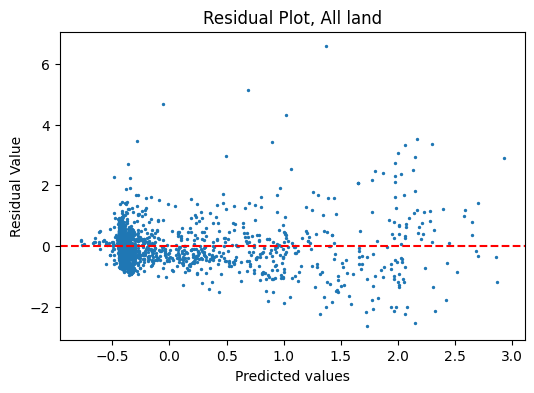

In [255]:
linreg2 =OLS(scaledy_all,scaledx_all).fit()
resid = linreg2.resid
plt.figure(figsize=(6,4))
plt.scatter(linreg2.fittedvalues,linreg2.resid,s=2)
plt.axhline(0,linestyle='--',color='r')
plt.title('Residual Plot, All land')
plt.xlabel('Predicted values')
plt.ylabel('Residual Value')

(array([-2.,  0.,  2.,  4.,  6.,  8., 10.]),
 [Text(-2.0, 0, '−2'),
  Text(0.0, 0, '0'),
  Text(2.0, 0, '2'),
  Text(4.0, 0, '4'),
  Text(6.0, 0, '6'),
  Text(8.0, 0, '8'),
  Text(10.0, 0, '10')])

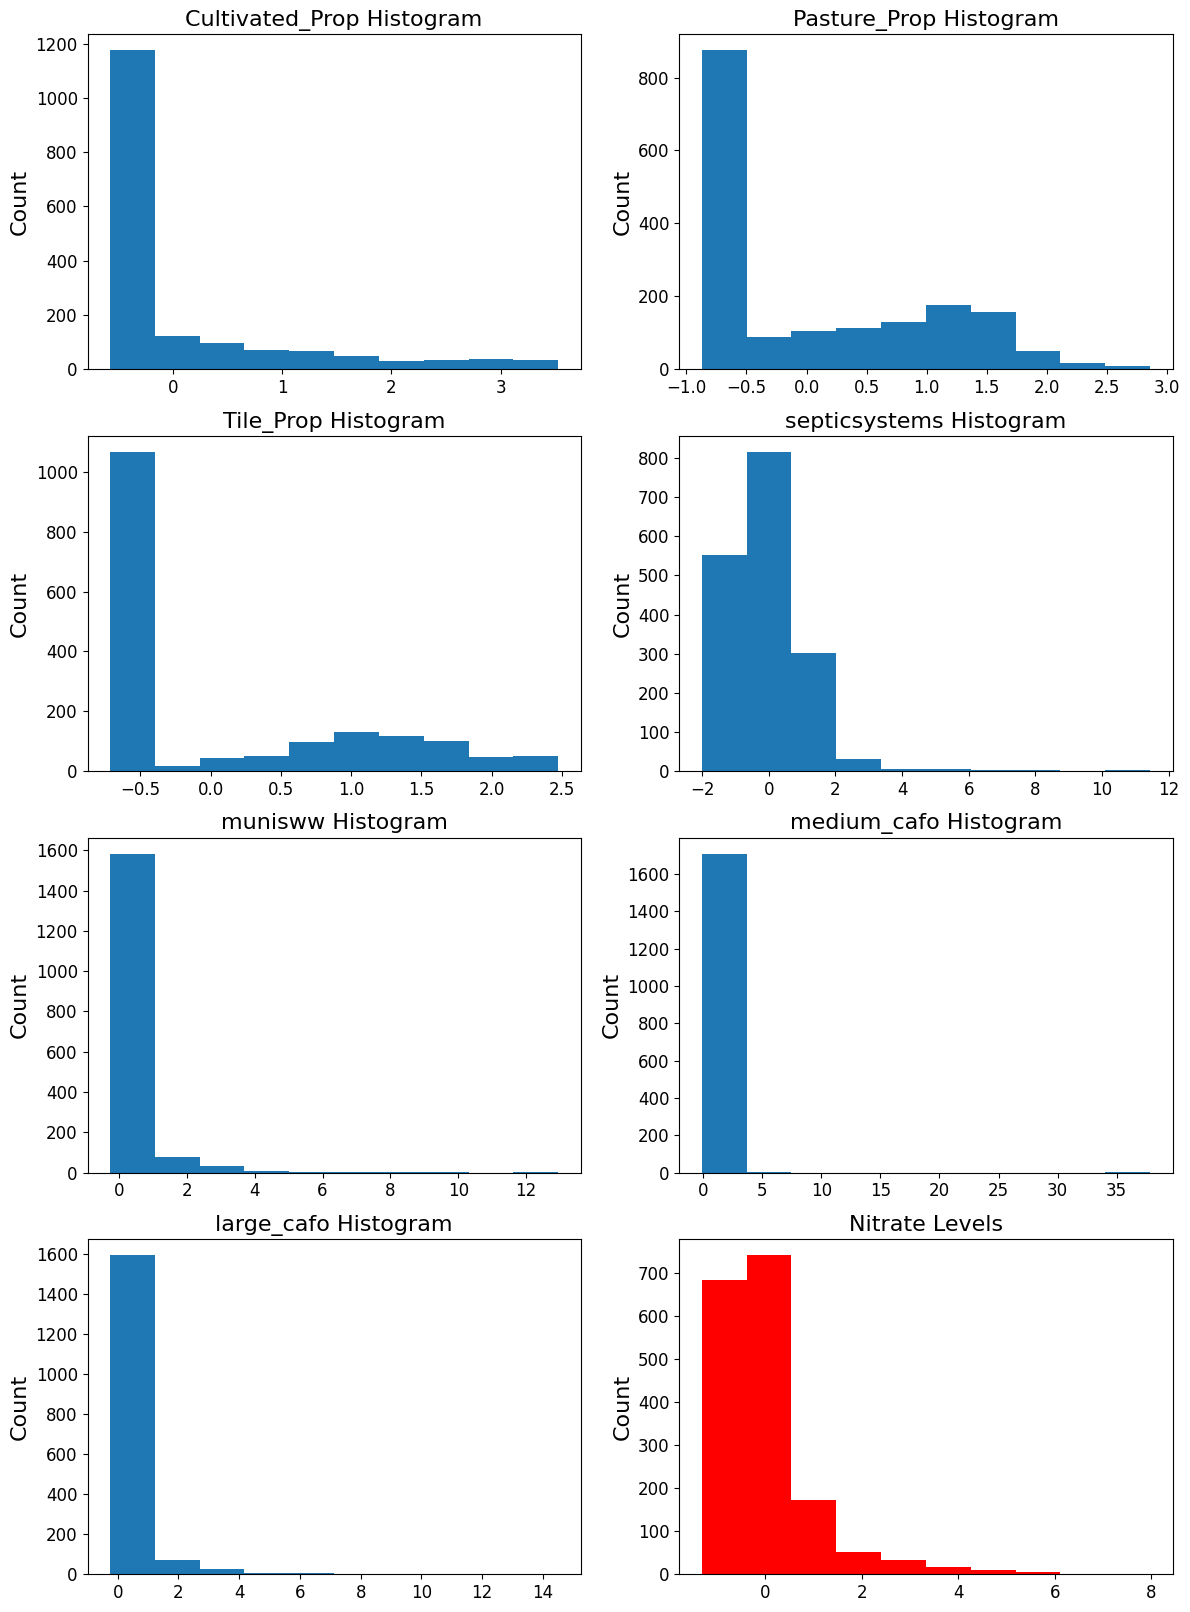

In [ ]:
#data skew
plt.figure(figsize=(14,20))
a=1
for i in scaledx_alldf:
    plt.subplot(4,2,a)
    plt.hist(scaledx_alldf[i])
    plt.title(f'{i} Histogram',fontsize=16)
    plt.ylabel('Count',fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    a+=1
plt.subplot(4,2,8)
plt.hist(scaledy_all,color='red')
plt.title('Nitrate Levels',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)


(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(-4.0, 0, '−4'),
  Text(-3.0, 0, '−3'),
  Text(-2.0, 0, '−2'),
  Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3')])

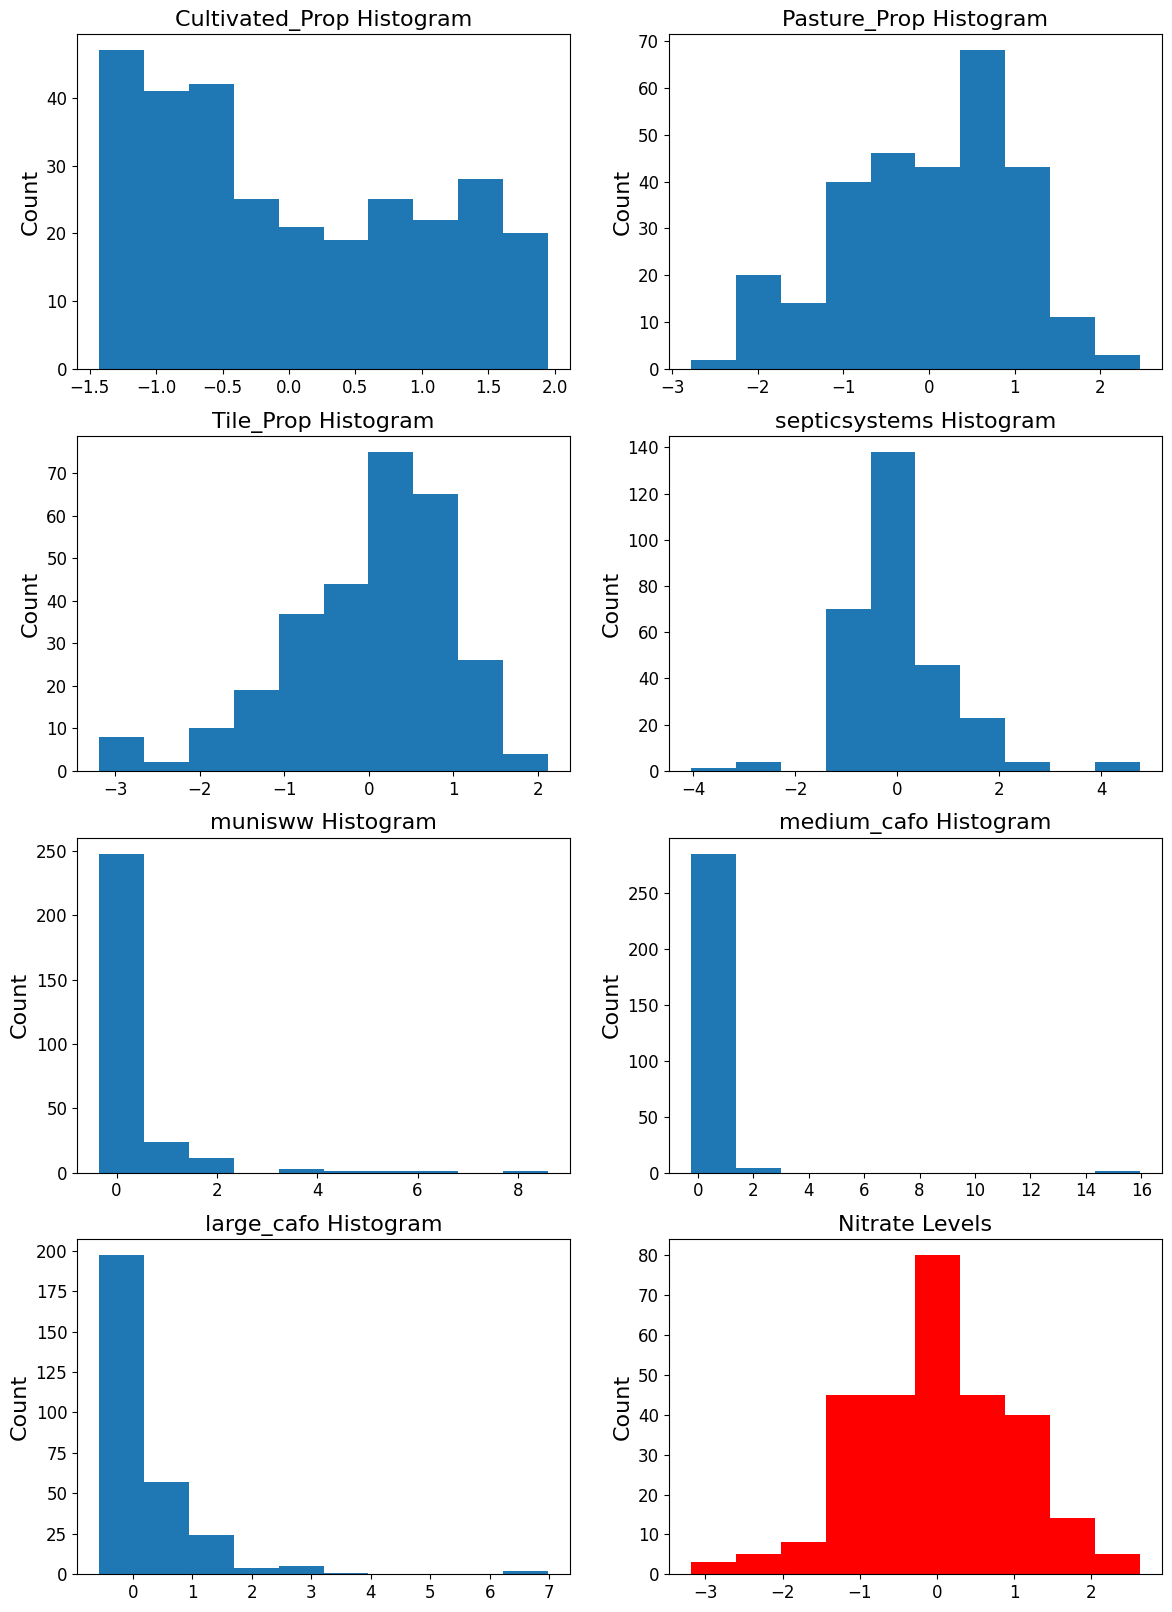

In [257]:
#data skew
plt.figure(figsize=(14,20))
a=1
for i in scaledx_onlydf:
    plt.subplot(4,2,a)
    plt.hist(scaledx_onlydf[i])
    plt.title(f'{i} Histogram',fontsize=16)
    plt.ylabel('Count',fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    a+=1
plt.subplot(4,2,8)
plt.hist(scaledy_only,color='red')
plt.title('Nitrate Levels',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

Text(0.5, 1.0, 'Q-Q Plot for Normality of Residuals, Cultivated Land')

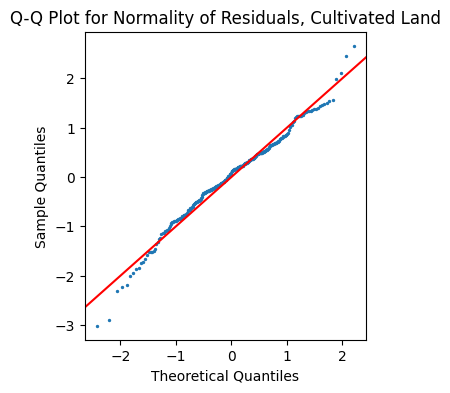

In [151]:
#Normal errors
import scipy.stats as st
model_residuals = linreg.resid
model_residuals_sorted = np.sort(model_residuals)
length = len(model_residuals_sorted)
expected = []
se2 = 1/(length-(scaledx_only.shape[1]+1))*((model_residuals**2).sum()) #-6 to remove bias
se = np.sqrt(se2) #^estimates for error
for i in range(length):
    ind = i/(length+1)
    expected.append(st.norm.ppf(ind,0,se))

#predicted = linreg2.predict(gages2)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.axline((0,0),slope=1,color='r')
plt.scatter(x=expected,y=model_residuals_sorted,s=2)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot for Normality of Residuals, Cultivated Land')

Text(0.5, 1.0, 'Q-Q Plot for Normality of Residuals, All land')

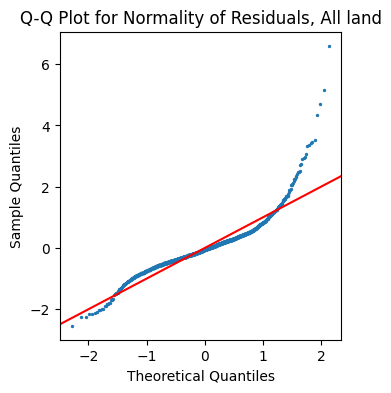

In [152]:
#Normal errors
import scipy.stats as st
model_residuals = linreg2.resid
model_residuals_sorted = np.sort(model_residuals)
length = len(model_residuals_sorted)
expected = []
se2 = 1/(length-(scaledx_all.shape[1]+1))*((model_residuals**2).sum()) #-6 to remove bias
se = np.sqrt(se2) #^estimates for error
for i in range(length):
    ind = i/(length+1)
    expected.append(st.norm.ppf(ind,0,se))

#predicted = linreg2.predict(gages2)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.axline((0,0),slope=1,color='r')
plt.scatter(x=expected,y=model_residuals_sorted,s=2)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot for Normality of Residuals, All land')

# Interactive Effects, All Land, OLS/WLS

In [83]:
aics=[]
bics=[]
adjr2=[]
predr = []
mse = []
regressions = ['I/A/OLS', 'I/A/WLS', 'I/O/OLS','I/O/WLS','A/OLS','A/WLS','O/OLS','O/WLS']

Interactive Effects/All land/OLS

In [84]:
from sklearn.metrics import r2_score, mean_squared_error

In [85]:
int_all_ols = OLS(scaledy_all,newdfxall).fit()
int_all_ols.summary()
int_all_ols_pval = int_all_ols.pvalues
int_all_ols_coeff = int_all_ols.params
r = []
r2 = []
bic = []
aic = []
ms = []
for i in range(1,5):
    xtrain,xtest,ytrain,ytest,counttrain,counttest = train_test_split(newdfxall,scaledy_all,allcounts,test_size=0.3,random_state=i)
    temp = OLS(ytrain,xtrain).fit()
    r.append(temp.rsquared_adj)
    bic.append(temp.bic)
    aic.append(temp.aic)
    r2.append(r2_score(ytest,temp.predict(xtest)))
    ms.append(mean_squared_error(ytest,temp.predict(xtest)))
aics.append(np.mean(aic))
bics.append(np.mean(bic))
adjr2.append(np.mean(r))
predr.append(np.mean(r2))
mse.append(np.mean(ms))

Interactive Effects/All land/WLS

In [86]:
int_all_wls = WLS(scaledy_all,newdfxall,allcounts).fit()
int_all_wls.summary()
int_all_wls_pval = int_all_wls.pvalues
int_all_wls_coeff = int_all_wls.params

for i in range(1,5):
    xtrain,xtest,ytrain,ytest,counttrain,counttest = train_test_split(newdfxall,scaledy_all,allcounts,test_size=0.3,random_state=i)
    temp = WLS(ytrain,xtrain,counttrain).fit()
    r.append(temp.rsquared_adj)
    bic.append(temp.bic)
    aic.append(temp.aic)
    r2.append(r2_score(ytest,temp.predict(xtest)))
    ms.append(mean_squared_error(ytest,temp.predict(xtest)))
aics.append(np.mean(aic))
bics.append(np.mean(bic))
adjr2.append(np.mean(r))
predr.append(np.mean(r2))
mse.append(np.mean(ms))

# Interactive Effects, Only cultivated land, OLS/WLS

I/O/OLS

In [87]:
int_only_ols = OLS(scaledy_only,newdfxonly).fit()
int_only_ols.summary()
int_only_ols_pval = int_only_ols.pvalues
int_only_ols_coeff = int_only_ols.params

for i in range(1,5):
    xtrain,xtest,ytrain,ytest,counttrain,counttest = train_test_split(newdfxonly,scaledy_only,onlycounts,test_size=0.3,random_state=i)
    temp = OLS(ytrain,xtrain).fit()
    r.append(temp.rsquared_adj)
    bic.append(temp.bic)
    aic.append(temp.aic)
    r2.append(r2_score(ytest,temp.predict(xtest)))
    ms.append(mean_squared_error(ytest,temp.predict(xtest)))
aics.append(np.mean(aic))
bics.append(np.mean(bic))
adjr2.append(np.mean(r))
predr.append(np.mean(r2))
mse.append(np.mean(ms))

I/O/WLS

In [88]:
int_only_wls = WLS(scaledy_only,newdfxonly,onlycounts).fit()
int_only_wls.summary()
int_only_wls_pval = int_only_wls.pvalues
int_only_wls_coeff = int_only_wls.params

for i in range(1,5):
    xtrain,xtest,ytrain,ytest,counttrain,counttest = train_test_split(newdfxonly,scaledy_only,onlycounts,test_size=0.3,random_state=i)
    temp = WLS(ytrain,xtrain,counttrain).fit()
    r.append(temp.rsquared_adj)
    bic.append(temp.bic)
    aic.append(temp.aic)
    r2.append(r2_score(ytest,temp.predict(xtest)))
    ms.append(mean_squared_error(ytest,temp.predict(xtest)))
aics.append(np.mean(aic))
bics.append(np.mean(bic))
adjr2.append(np.mean(r))
predr.append(np.mean(r2))
mse.append(np.mean(ms))

# No Interactive Effects, All land, OLS/WLS

In [89]:
all_ols = OLS(scaledy_all,scaledx_alldf).fit()
all_ols.summary()
all_ols_pval = all_ols.pvalues
all_ols_coeff = all_ols.params

for i in range(1,5):
    xtrain,xtest,ytrain,ytest,counttrain,counttest = train_test_split(scaledx_alldf,scaledy_all,allcounts,test_size=0.3,random_state=i)
    temp = OLS(ytrain,xtrain).fit()
    r.append(temp.rsquared_adj)
    bic.append(temp.bic)
    aic.append(temp.aic)
    r2.append(r2_score(ytest,temp.predict(xtest)))
    ms.append(mean_squared_error(ytest,temp.predict(xtest)))
aics.append(np.mean(aic))
bics.append(np.mean(bic))
adjr2.append(np.mean(r))
predr.append(np.mean(r2))
mse.append(np.mean(ms))

In [90]:
all_wls = WLS(scaledy_all,scaledx_alldf,allcounts).fit()
all_wls.summary()
all_wls_pval = all_wls.pvalues
all_wls_coeff = all_wls.params

for i in range(1,5):
    xtrain,xtest,ytrain,ytest,counttrain,counttest = train_test_split(scaledx_alldf,scaledy_all,allcounts,test_size=0.3,random_state=i)
    temp = WLS(ytrain,xtrain,counttrain).fit()
    r.append(temp.rsquared_adj)
    bic.append(temp.bic)
    aic.append(temp.aic)
    r2.append(r2_score(ytest,temp.predict(xtest)))
    ms.append(mean_squared_error(ytest,temp.predict(xtest)))
aics.append(np.mean(aic))
bics.append(np.mean(bic))
adjr2.append(np.mean(r))
predr.append(np.mean(r2))
mse.append(np.mean(ms))

# No Interactive Effects, Only cultivated land, OLS/WLS

In [91]:
only_ols = OLS(scaledy_only,scaledx_onlydf).fit()
only_ols.summary()
only_ols_pval = only_ols.pvalues
only_ols_coeff = only_ols.params

for i in range(1,5):
    xtrain,xtest,ytrain,ytest,counttrain,counttest = train_test_split(scaledx_onlydf,scaledy_only,onlycounts,test_size=0.3,random_state=i)
    temp = OLS(ytrain,xtrain).fit()
    r.append(temp.rsquared_adj)
    bic.append(temp.bic)
    aic.append(temp.aic)
    r2.append(r2_score(ytest,temp.predict(xtest)))
    ms.append(mean_squared_error(ytest,temp.predict(xtest)))
aics.append(np.mean(aic))
bics.append(np.mean(bic))
adjr2.append(np.mean(r))
predr.append(np.mean(r2))
mse.append(np.mean(ms))

In [92]:
only_wls = WLS(scaledy_only,scaledx_onlydf,onlycounts).fit()
only_wls.summary()
only_wls_pval = only_wls.pvalues
only_wls_coeff = only_wls.params

for i in range(1,5):
    xtrain,xtest,ytrain,ytest,counttrain,counttest = train_test_split(scaledx_onlydf,scaledy_only,onlycounts,test_size=0.3,random_state=i)
    temp = WLS(ytrain,xtrain,counttrain).fit()
    r.append(temp.rsquared_adj)
    bic.append(temp.bic)
    aic.append(temp.aic)
    r2.append(r2_score(ytest,temp.predict(xtest)))
    ms.append(mean_squared_error(ytest,temp.predict(xtest)))
aics.append(np.mean(aic))
bics.append(np.mean(bic))
adjr2.append(np.mean(r))
predr.append(np.mean(r2))
mse.append(np.mean(ms))

We have 8 models. Let's look at AIC, BIC, adjusted R^2

In [93]:
aics=np.array(aics)
bics=np.array(bics)
adjr2=np.array(adjr2)
r2 = np.array(predr)
mse = np.array(mse)

In [94]:
scorez = pd.DataFrame([aics,bics,adjr2,predr,mse],columns=regressions,index=['CV_AIC','CV_BIC','CV_Adjusted_R2','CV_Predictive_R2','CV_MSE'])

In [95]:
scorez

,I/A/OLS,I/A/WLS,I/O/OLS,I/O/WLS,A/OLS,A/WLS,O/OLS,O/WLS
CV_AIC,2556.754113,2990.679055,2176.121673,1764.917637,1926.890751,2203.800424,1964.592835,1787.275822
CV_BIC,2699.252921,3133.177864,2302.044135,1882.551924,2028.123122,2294.098183,2045.304121,1860.797252
CV_Adjusted_R2,0.525697,0.572409,0.453797,0.462172,0.471775,0.485772,0.446592,0.440130
CV_Predictive_R2,0.475361,0.433226,0.330656,0.280639,0.322168,0.338351,0.315170,0.295894
CV_MSE,0.499266,0.538440,0.665499,0.728597,0.680256,0.659247,0.689538,0.714250


In [96]:
colname = newdfxall.columns

In [97]:
coefftracker=pd.DataFrame(index=regressions,columns=colname)
pvaltracker=pd.DataFrame(index=regressions,columns=colname)

In [98]:
only_ols_coeff.shape

(7,)

In [99]:
int_only_ols_coeff.shape

(28,)

In [100]:
only_ols_coeff=np.pad(only_ols_coeff,(0,21),'constant',constant_values=0)
only_wls_coeff=np.pad(only_wls_coeff,(0,21),'constant',constant_values=0)
all_ols_coeff=np.pad(all_ols_coeff,(0,21),'constant',constant_values=0)
all_wls_coeff=np.pad(all_wls_coeff,(0,21),'constant',constant_values=0)

In [101]:
only_ols_pval=np.pad(only_ols_pval,(0,21),'constant',constant_values=1) #28 when bmp included)
only_wls_pval=np.pad(only_wls_pval,(0,21),'constant',constant_values=1)
all_ols_pval=np.pad(all_ols_pval,(0,21),'constant',constant_values=1)
all_wls_pval=np.pad(all_wls_pval,(0,21),'constant',constant_values=1)

In [102]:
coeffs = np.array([int_all_ols_coeff,int_all_wls_coeff,int_only_ols_coeff,int_only_wls_coeff,
                   all_ols_coeff,all_wls_coeff,only_ols_coeff,only_wls_coeff])

In [103]:
pvals = np.array([int_all_ols_pval,int_all_wls_pval,int_only_ols_pval,int_only_wls_pval,
                   all_ols_pval,all_wls_pval,only_ols_pval,only_wls_pval])

In [104]:
indices = np.array(regressions)
a=0
for i in coefftracker.index:
    coefftracker.loc[i]=coeffs[a]
    pvaltracker.loc[i]=pvals[a]
    a+=1

In [107]:
isitsignificant = pvaltracker[pvaltracker<0.05]

In [109]:
timessignificant = {}
for i in isitsignificant.columns:
    timessignificant[i] = isitsignificant[i].notna().sum()


In [129]:

binary_df = isitsignificant.notna().astype(int)
binary_df

,Cultivated_Prop,Pasture_Prop,Tile_Prop,septicsystems,munisww,small_cafo,large_cafo,Cultivated_Prop*Pasture_Prop,Cultivated_Prop*Tile_Prop,Cultivated_Prop*septicsystems,...,Tile_Prop*septicsystems,Tile_Prop*munisww,Tile_Prop*small_cafo,Tile_Prop*large_cafo,septicsystems*munisww,septicsystems*small_cafo,septicsystems*large_cafo,munisww*small_cafo,munisww*large_cafo,small_cafo*large_cafo
I/A/OLS,1,0,1,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,1,0
I/A/WLS,1,0,1,1,0,0,0,1,1,1,...,1,0,0,1,0,0,0,0,0,0
I/O/OLS,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I/O/WLS,1,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
A/OLS,1,0,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A/WLS,1,1,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O/OLS,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O/WLS,1,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
binary_df=binary_df.transpose()

In [50]:
import matplotlib as mpl

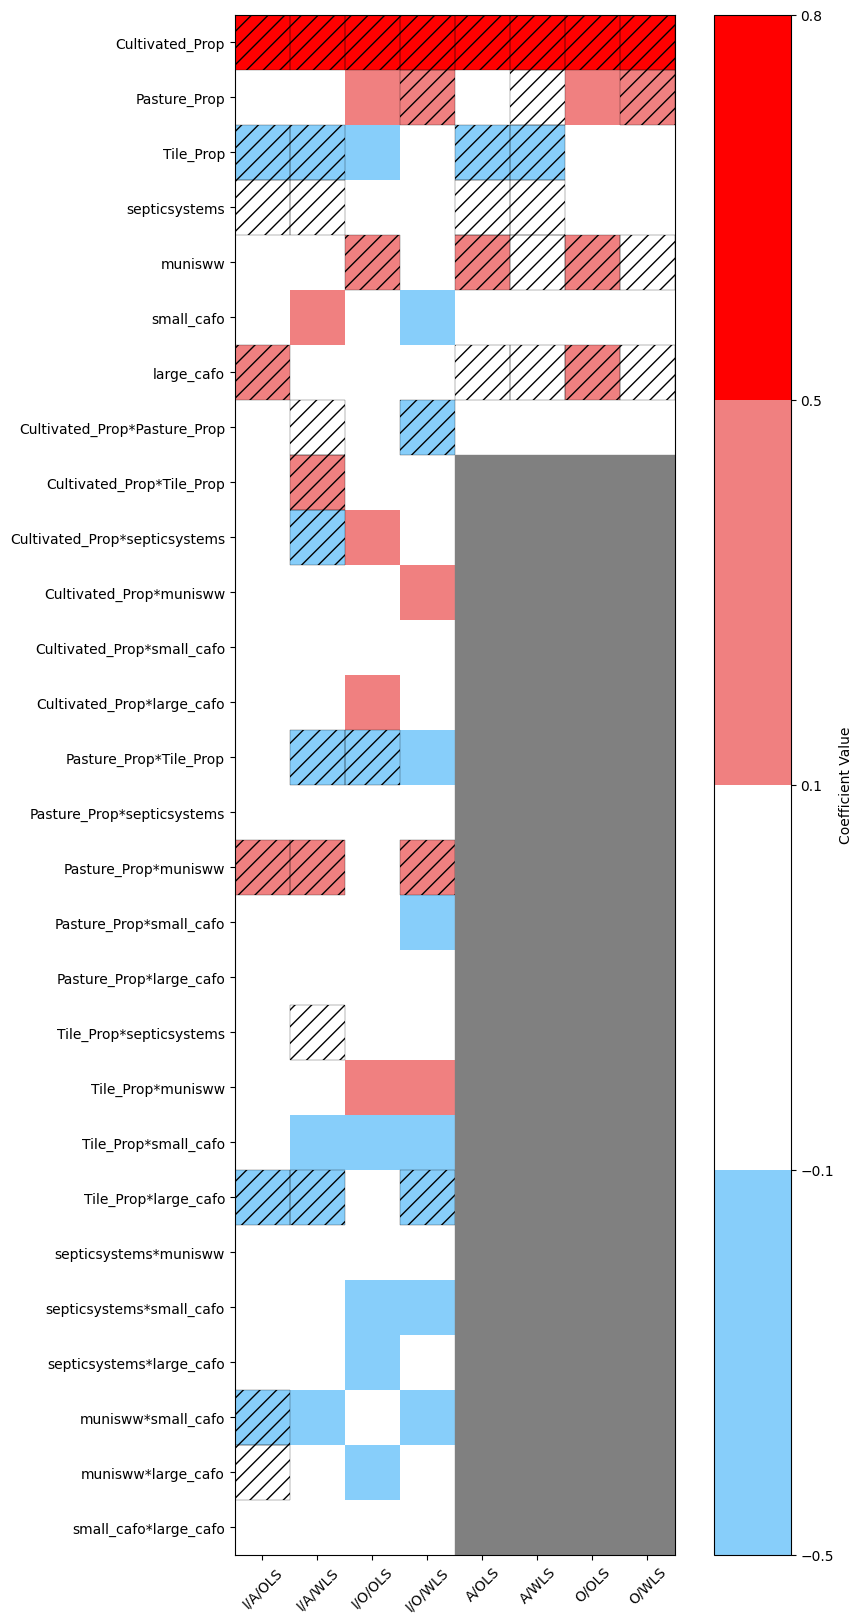

In [132]:
fig, ax = plt.subplots(figsize=(10,20))
trnn = coefftracker.transpose()
trnn=trnn.apply(pd.to_numeric, errors='coerce')
sm = plt.cm.bwr
cmap = (mpl.colors.ListedColormap(['lightskyblue', 'white', 'lightcoral', 'red'])
        .with_extremes(over='red', under='blue'))
bounds = [-.5, -0.1, 0.1, 0.5,0.8]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cax = ax.imshow(trnn,cmap=cmap,norm=norm)
ax.set_xticks(np.arange(trnn.shape[1]))
ax.set_yticks(np.arange(trnn.shape[0]))
ax.set_xticklabels(trnn.columns,rotation=45)
ax.set_yticklabels(trnn.index)
fig.colorbar(cax,label="Coefficient Value")
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
for i in range(binary_df.shape[0]):
    for j in range(binary_df.shape[1]):
        if binary_df.iloc[i, j] == 1:
            # You can customize hatch styles, here I use '//' as an example
            ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, hatch='//', fill=False, linewidth=0.2))

mask=plt.Rectangle((3.5,7.5),4,28,color='gray',hatch='/')
ax.add_patch(mask)
plt.show()

In [134]:
coefftracker2 = coefftracker.loc[['I/O/OLS','I/O/WLS','O/OLS','O/WLS']]

In [135]:
coefftracker2

,Cultivated_Prop,Pasture_Prop,Tile_Prop,septicsystems,munisww,small_cafo,large_cafo,Cultivated_Prop*Pasture_Prop,Cultivated_Prop*Tile_Prop,Cultivated_Prop*septicsystems,...,Tile_Prop*septicsystems,Tile_Prop*munisww,Tile_Prop*small_cafo,Tile_Prop*large_cafo,septicsystems*munisww,septicsystems*small_cafo,septicsystems*large_cafo,munisww*small_cafo,munisww*large_cafo,small_cafo*large_cafo
I/O/OLS,0.506957,0.174191,-0.115942,0.050301,0.197517,0.008135,0.039123,-0.056182,0.003899,0.124968,...,-0.073859,0.164492,-0.125955,-0.065195,0.038207,-0.311792,-0.103033,0.05742,-0.106869,0.016437
I/O/WLS,0.67701,0.351853,-0.044343,-0.072136,0.024277,-0.236044,0.029094,-0.117173,0.093499,0.003984,...,-0.008238,0.126001,-0.1034,-0.161848,-0.060111,-0.285296,-0.05637,-0.272373,0.067486,0.063005
O/OLS,0.505857,0.114652,-0.059949,0.059789,0.180194,0.069538,0.120062,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O/WLS,0.66431,0.199347,0.057218,0.063557,0.09266,0.052335,0.088132,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
binary_df2 = binary_df[['I/O/OLS','I/O/WLS','O/OLS','O/WLS']]

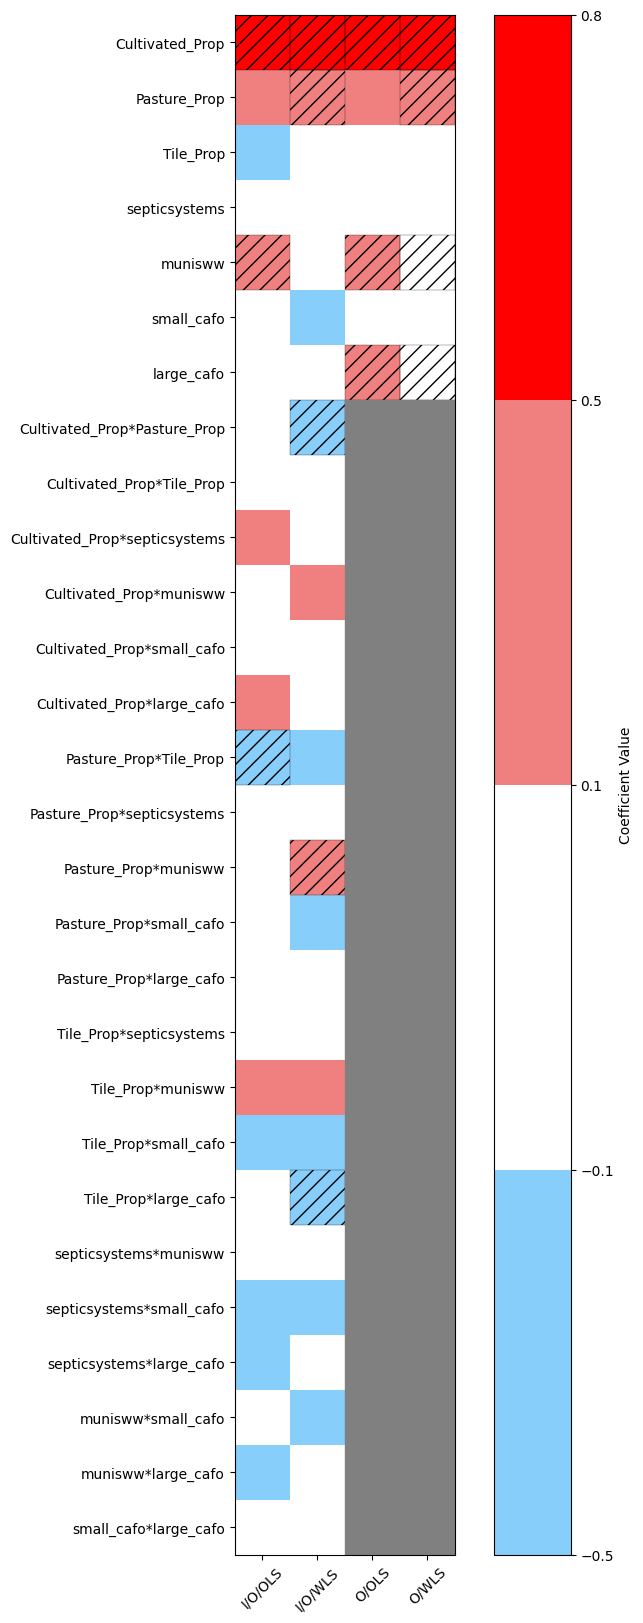

In [143]:
fig, ax = plt.subplots(figsize=(10,20))
#trnn = coefftracker2.transpose()
trnn=trnn.apply(pd.to_numeric, errors='coerce')
sm = plt.cm.bwr
cmap = (mpl.colors.ListedColormap(['lightskyblue', 'white', 'lightcoral', 'red'])
        .with_extremes(over='red', under='blue'))
bounds = [-.5, -0.1, 0.1, 0.5,0.8]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cax = ax.imshow(trnn,cmap=cmap,norm=norm)
ax.set_xticks(np.arange(trnn.shape[1]))
ax.set_yticks(np.arange(trnn.shape[0]))
ax.set_xticklabels(trnn.columns,rotation=45)
ax.set_yticklabels(trnn.index)
fig.colorbar(cax,label="Coefficient Value")
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
for i in range(binary_df2.shape[0]):
    for j in range(binary_df2.shape[1]):
        if binary_df2.iloc[i, j] == 1:
            # You can customize hatch styles, here I use '//' as an example
            ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, hatch='//', fill=False, linewidth=0.2))

mask=plt.Rectangle((1.5,6.5),2,28,color='gray',hatch='/')
ax.add_patch(mask)
plt.show()

# Splitting the frame based on Cultivated Crop Proportion

In [145]:

#ONLY crop>0, first 8 predictors
df1_indices = scaledx_onlydf[scaledx_onlydf['Cultivated_Prop'] < 0.0].index

df3_indices = scaledx_onlydf[scaledx_onlydf['Cultivated_Prop'] >= 0.0].index

scxo1 = scaledx_onlydf[scaledx_onlydf['Cultivated_Prop'] < 0.0].drop('Name',axis=1)

scxo3 = scaledx_onlydf[scaledx_onlydf['Cultivated_Prop'] >= 0.0].drop('Name',axis=1)

scyo1 = scaledy_only[df1_indices]

scyo3 = scaledy_only[df3_indices]


cto1 = onlycounts.loc[df1_indices].reset_index(drop=True)

cto3 = onlycounts.loc[df3_indices].reset_index(drop=True)


In [146]:
pval_reg = {}
cof_reg = {}


#Only
#OLS
reg1_all = OLS(scyo1,scxo1).fit()
pval_reg['Regime_1_o/o'] = np.array(reg1_all.pvalues)
cof_reg['Regime_1_o/o'] = reg1_all.params


reg3_all = OLS(scyo3,scxo3).fit()
reg3_all.summary()
pval_reg['Regime_2_o/o'] = reg3_all.pvalues
cof_reg['Regime_2_o/o'] = reg3_all.params


#WLS
reg1_all = WLS(scyo1,scxo1,cto1).fit()
reg1_all.summary()
pval_reg['Regime_1_o/w'] = reg1_all.pvalues
cof_reg['Regime_1_o/w'] = reg1_all.params



reg3_all = WLS(scyo3,scxo3,cto3).fit()
reg3_all.summary()
pval_reg['Regime_2_o/w'] = reg3_all.pvalues
cof_reg['Regime_2_o/w'] = reg3_all.params



In [ ]:
pval_stratified = pd.DataFrame(pval_reg)
coef_stratified=pd.DataFrame(cof_reg)
isitsignificant = pval_stratified[pval_stratified<0.05]
binary_dfstrat = isitsignificant.notna().astype(int)
binary_dfstrat

,Regime_1_o/o,Regime_2_o/o,Regime_1_o/w,Regime_2_o/w
Cultivated_Prop,1,0,1,1
Pasture_Prop,1,0,1,0
Tile_Prop,1,0,1,0
septicsystems,0,0,0,0
munisww,1,1,0,0
medium_cafo,0,0,0,0
large_cafo,0,1,0,0


In [ ]:
coef_stratified2 = coef_stratified[['Regime_1_o/o','Regime_2_o/o','Regime_3_o/o','Regime_1_o/w','Regime_2_o/w','Regime_3_o/w']]
binary_dfstrat2 = binary_dfstrat[['Regime_1_o/o','Regime_2_o/o','Regime_3_o/o','Regime_1_o/w','Regime_2_o/w','Regime_3_o/w']]

In [147]:
pval_stratified = pd.DataFrame(pval_reg)
coef_stratified=pd.DataFrame(cof_reg)
isitsignificant = pval_stratified[pval_stratified<0.05]
binary_dfstrat = isitsignificant.notna().astype(int)
binary_dfstrat
coef_stratified2 = coef_stratified.copy()
binary_dfstrat2 = binary_dfstrat.copy()
coef_stratified2=coef_stratified2.transpose()
binary_dfstrat2=binary_dfstrat2.transpose()

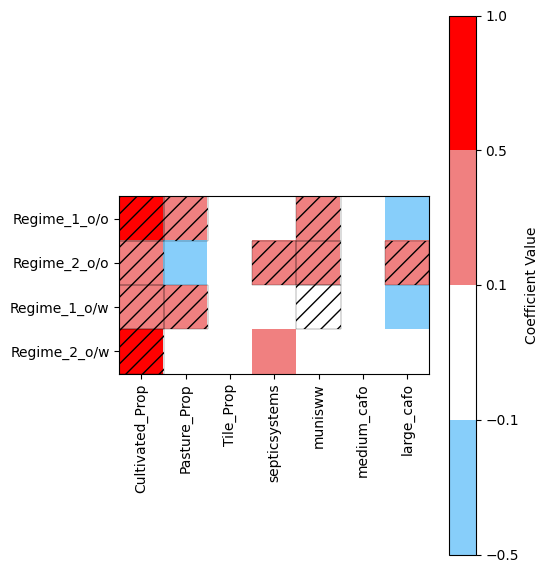

In [148]:
fig, ax = plt.subplots(figsize=(5,7))

coef_stratified2=coef_stratified2.apply(pd.to_numeric, errors='coerce')
#sm = plt.cm.bwr
cmap = (mpl.colors.ListedColormap(['lightskyblue', 'white', 'lightcoral', 'red'])
        .with_extremes(over='red', under='blue'))
bounds = [-.5, -0.1, 0.1, 0.5,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cax = ax.imshow(coef_stratified2,cmap=cmap,norm=norm)
ax.set_xticks(np.arange(coef_stratified2.shape[1]))
ax.set_yticks(np.arange(coef_stratified2.shape[0]))
ax.set_xticklabels(coef_stratified2.columns,rotation=90)
ax.set_yticklabels(coef_stratified2.index)
fig.colorbar(cax,label="Coefficient Value")
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
for i in range(binary_dfstrat2.shape[0]):
    for j in range(binary_dfstrat2.shape[1]):
        if binary_dfstrat2.iloc[i, j] == 1:
            # You can customize hatch styles, here I use '//' as an example
            ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, hatch='//', fill=False, linewidth=0.2))

#mask=plt.Rectangle((3.5,7.5),4,28,color='gray',hatch='/')
#ax.add_patch(mask)
plt.show()

In [63]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [140]:
X = np.array(list(zip(scaledx_onlydf['Cultivated_Prop'], scaledx_onlydf['Tile_Prop']))).reshape(len(scaledx_onlydf), 2)

In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
    
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / X.shape[0])
    
    inertias.append(kmeanModel.inertia_)
    
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]
#code from https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

Distortion values:
1 : 1.9999999999999984
2 : 1.033954320595366
3 : 0.6019580236906681
4 : 0.5101634896210826
5 : 0.3681586411046788
6 : 0.3256805691731466
7 : 0.27601322953290597
8 : 0.2323410561241637
9 : 0.21477336088258345


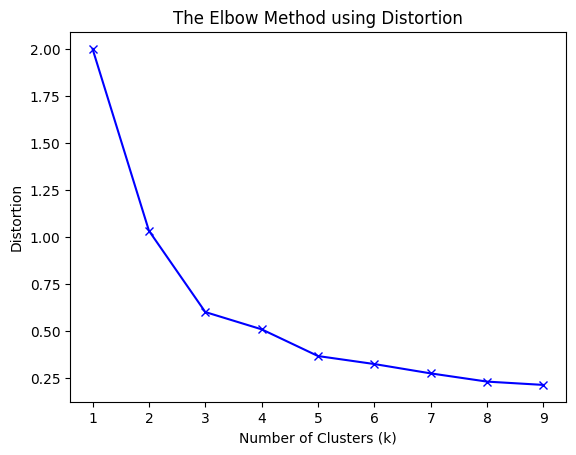

In [127]:
print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Inertia values:
1 : 579.9999999999999
2 : 299.8467529726563
3 : 174.56782687029354
4 : 147.9474119901139
5 : 106.7660059203568
6 : 94.44736506021245
7 : 80.0438365645427
8 : 67.37890627600748
9 : 62.284274655949176


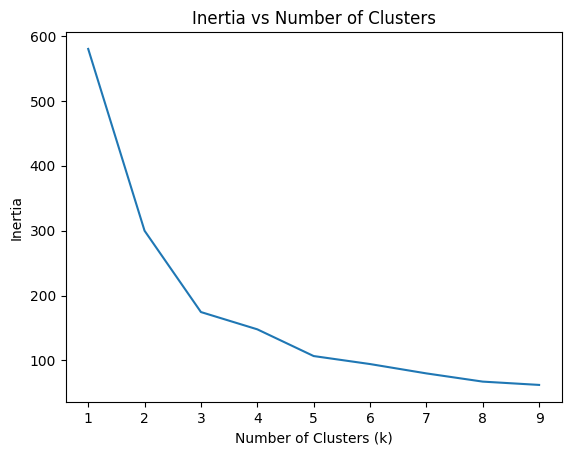

In [117]:
print("Inertia values:")
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of Clusters')
plt.show()

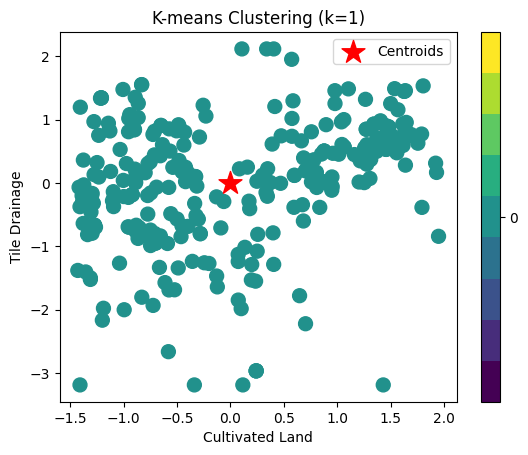

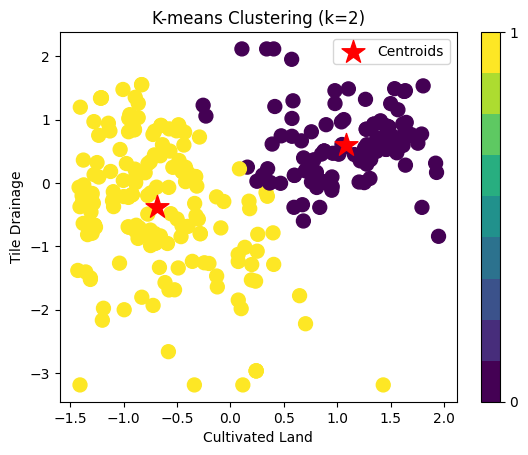

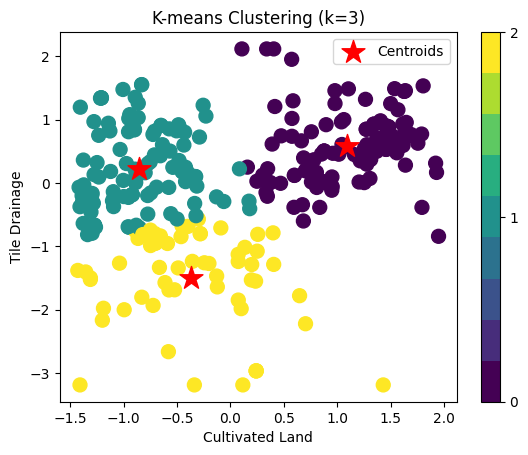

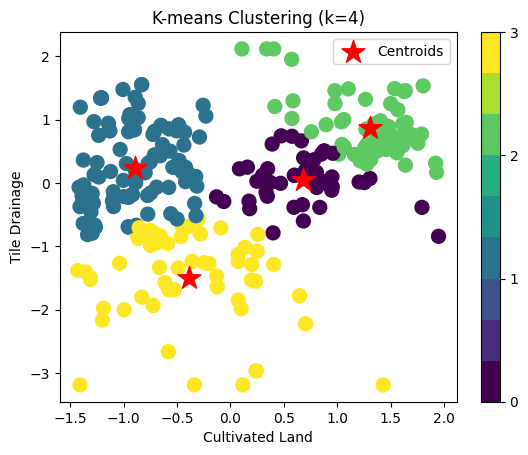

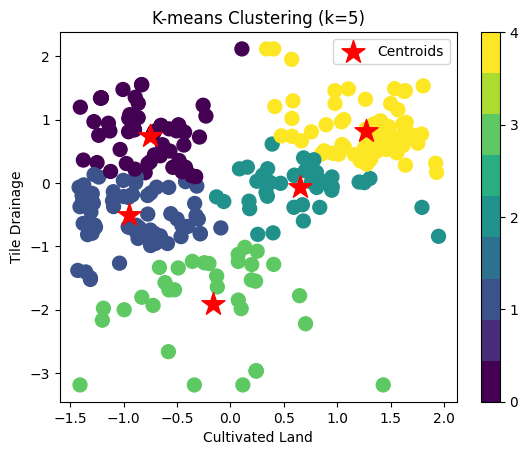

In [144]:
k_range = range(1, 6)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    y_kmeans = kmeans.fit_predict(X)
    
    map = plt.get_cmap('viridis', i)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap=map, marker='o', s=100)
    plt.colorbar(ticks=np.arange(i))
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                s=300, c='red', label='Centroids',marker='*')
    plt.title(f'K-means Clustering (k={k})')
    plt.xlabel('Cultivated Land')
    plt.ylabel('Tile Drainage')
    plt.legend()

    plt.show()

In [149]:
X = np.array(list(zip(scaledx_onlydf['Cultivated_Prop'], scaledx_onlydf['Tile_Prop']))).reshape(len(scaledx_onlydf), 2)
k=3
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)

In [150]:
x_only_cluster = scaledx_onlydf.copy()
x_only_cluster['cluster']=kmeans.labels_
y_on_cluster = pd.DataFrame(scaledy_only)
y_on_cluster['cluster']=kmeans.labels_
xcnt_clust = pd.DataFrame(onlycounts)
xcnt_clust['cluster']=kmeans.labels_

In [151]:
pval_reg = {}
cof_reg = {}
for i in range(k):
    X=x_only_cluster[x_only_cluster['cluster']==i].drop(['Name','cluster'],axis=1)
    y=np.array(y_on_cluster[y_on_cluster['cluster']==i].drop('cluster',axis=1))
    wait = xcnt_clust[xcnt_clust['cluster']==i].drop('cluster',axis=1)
    reg = OLS(y,X).fit()
    pval_reg['cluster_'f'{i}_OLS'] = np.array(reg.pvalues)
    cof_reg[f'{i}_OLS'] = (reg.params)
    wl = WLS(y,X,wait).fit()
    pval_reg[f'{i}_WLS'] = np.array(wl.pvalues)
    cof_reg[f'{i}_WLS'] = (wl.params)




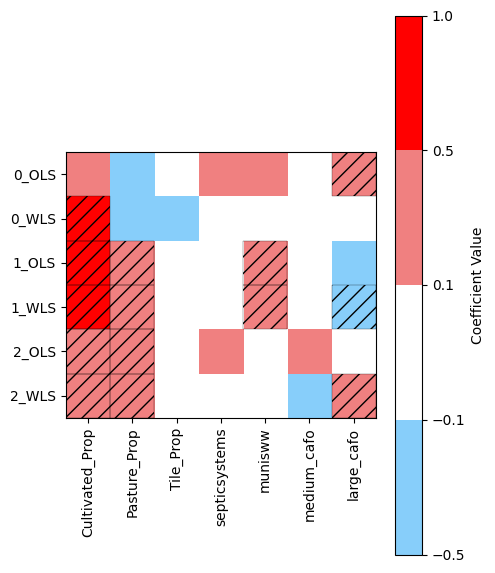

In [152]:
pval_stratified = pd.DataFrame(pval_reg)
coef_stratified=pd.DataFrame(cof_reg)
isitsignificant = pval_stratified[pval_stratified<0.05]
binary_dfstrat = isitsignificant.notna().astype(int)
binary_dfstrat
coef_stratified2 = coef_stratified.copy()
binary_dfstrat2 = binary_dfstrat.copy()
coef_stratified2=coef_stratified2.transpose()
binary_dfstrat2=binary_dfstrat2.transpose()

fig, ax = plt.subplots(figsize=(5,7))

coef_stratified2=coef_stratified2.apply(pd.to_numeric, errors='coerce')
#sm = plt.cm.bwr
cmap = (mpl.colors.ListedColormap(['lightskyblue', 'white', 'lightcoral', 'red'])
        .with_extremes(over='red', under='blue'))
bounds = [-.5, -0.1, 0.1, 0.5,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cax = ax.imshow(coef_stratified2,cmap=cmap,norm=norm)
ax.set_xticks(np.arange(coef_stratified2.shape[1]))
ax.set_yticks(np.arange(coef_stratified2.shape[0]))
ax.set_xticklabels(coef_stratified2.columns,rotation=90)
ax.set_yticklabels(coef_stratified2.index)
fig.colorbar(cax,label="Coefficient Value")
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
for i in range(binary_dfstrat2.shape[0]):
    for j in range(binary_dfstrat2.shape[1]):
        if binary_dfstrat2.iloc[i, j] == 1:
            # You can customize hatch styles, here I use '//' as an example
            ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, hatch='//', fill=False, linewidth=0.2))

#mask=plt.Rectangle((3.5,7.5),4,28,color='gray',hatch='/')
#ax.add_patch(mask)
plt.show()